In [1]:
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Notes for users
## Installation
- all packages required are listed above, namely numpy, scipy and matplotlib (visualization - optional)
- I recommend running in a Jupyter notebook
- pulling the entire repository is also required to get all the accompanying files such as model saves and datasets
## User Guide
- run this notebook mostly sequentially, I recommend skipping the training stages as they take quite long and using the saved models instead
- this notebook is intended for people who are able to read code, it is a proof-of-concept and in no way, shape or form intended for any actual use
# Inspiration/Source
- heavy inspiration for this work has been taken from the Neural Networks from Scratch by Harrison Kinsley and Daniel Kukiela available at https://nnfs.io/, code for the LayerDense, ActivationReLU, ActivationSoftmaxLossCategoricalCrossentropy and OptimizerSGD classes were taken directly from the book with some but often only limited modifications
- the LayerConvolutional, LayerMaxPooling, LayerFlatten and Network classes were written entirely by me

In [2]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [4]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(n_images, n_rows, n_cols)
        return images, n_images


def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = np.frombuffer(data, dtype=np.uint8, offset=8)
        return labels


x, num_inputs = read_mnist_images('../mnist/train-images.idx3-ubyte')
x = x.reshape((-1, 1, 28, 28))
x = x / 255.
y = one_hot_encode(read_mnist_labels('../mnist/train-labels.idx1-ubyte'), 10)

In [5]:
class LayerDense:
    def __init__(self, n_inputs, n_neurons):
        rng = np.random.default_rng()
        variance = np.sqrt(6/(n_inputs + n_neurons))
        self.weights = (rng.standard_normal(size=(n_inputs, n_neurons))) * variance # xavier initialization from tensorflow
        self.biases = np.zeros((1, n_neurons))
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

    def __getitem__(self, item):
        if item == 'weights':
            return self.weights
        elif item == 'biases':
            return self.biases
        elif item == 'n_inputs':
            return self.n_inputs
        elif item == 'n_neurons':
            return self.n_neurons

    def __setitem__(self, key, value):
        if key == 'weights':
            self.weights = value
        elif key == 'biases':
            self.biases = value
        elif key == 'n_neurons':
            self.n_neurons = value
        elif key == 'n_inputs':
            self.n_inputs = value

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs


    def backward(self, d_values):
        self.dweights = np.dot(self.inputs.T, d_values) / len(self.inputs)
        self.dbiases = np.sum(d_values, axis=0, keepdims=True) / len(self.inputs)
        self.dinputs = np.dot(d_values, self.weights.T) / len(self.inputs)

In [6]:
class LayerConvolutional:
    def __init__(self, num_kernels, num_channels, kernel_size):
        rng = np.random.default_rng()
        variance = np.sqrt(6/(2*num_kernels*num_channels*kernel_size*kernel_size))
        self.weights = (2*rng.standard_normal(size=(num_kernels, num_channels, kernel_size, kernel_size))) * variance
        self.biases = np.zeros(num_kernels)
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.num_channels = num_channels

    def __getitem__(self, item):
        if item == 'weights':
            return self.weights
        elif item == 'biases':
            return self.biases
        elif item == 'num_kernels':
            return self.num_kernels
        elif item == 'num_channels':
            return self.num_channels
        elif item == 'kernel_size':
            return self.kernel_size

    def __setitem__(self, key, value):
        if key == 'weights':
            self.weights = value
        elif key == 'biases':
            self.biases = value
        elif key == 'num_kernels':
            self.num_kernels = value
        elif key == 'num_channels':
            self.num_channels = value
        elif key == 'kernel_size':
            self.kernel_size = value
    
    def forward(self, inputs):
        if hasattr(self, 'output'):
            delattr(self, 'output')
        self.pad_size_rows = inputs.shape[-2] - (inputs.shape[-2] - self.kernel_size + 1)
        self.pad_size_cols = inputs.shape[-1] - (inputs.shape[-1] - self.kernel_size + 1)
        self.inputs = inputs
        self.padded_inputs = np.pad(inputs, ((0, 0), (0, 0), (0, self.pad_size_rows), (0, self.pad_size_cols)))
        if self.num_channels != self.inputs.shape[1]:
            raise Exception('Error: number of filter and image channels does not match.')
        for kernel, bias in zip(self.weights, self.biases):
            if not hasattr(self, 'output'):
                self.output = sp.signal.convolve(self.padded_inputs, [kernel], mode='valid') + bias
            else:
                self.output = np.append(self.output, sp.signal.convolve(self.padded_inputs, [kernel], mode='valid') + bias, axis=1)
    
    def backward(self, d_values):
        self.dbiases = np.zeros_like(self.biases)
        self.dinputs = np.zeros_like(self.inputs)
        if hasattr(self, 'dweights'):
            delattr(self, 'dweights')
        for kernel_id in range(self.num_kernels):
            kernel = self.weights[kernel_id]
            rotated_kernel = np.rot90(kernel, k=2, axes=(1, 2))
            per_kernel_dvalues = d_values[:, kernel_id:(kernel_id+1), :, :]
            for channel_id in range(self.num_channels):
                channel_rot_kernel = rotated_kernel[channel_id]
                channel_inputs = self.padded_inputs[:, channel_id:channel_id+1, :, :]
                if channel_id == 0:
                    cur_dfilter = sp.signal.convolve(channel_inputs, per_kernel_dvalues, mode='valid').reshape((-1, 1, self.kernel_size, self.kernel_size))
                else:
                    cur_dfilter = np.append(cur_dfilter, sp.signal.convolve(channel_inputs, per_kernel_dvalues, mode='valid').reshape((-1, 1, self.kernel_size, self.kernel_size)), axis=1)
                self.dinputs[:, channel_id:channel_id+1, :, :] += sp.signal.convolve(per_kernel_dvalues, [[channel_rot_kernel]], mode='full')[:, :, (self.pad_size_rows//2):-(self.pad_size_rows//2), (self.pad_size_cols//2):-(self.pad_size_cols//2)]
            if not hasattr(self, 'dweights'):
                self.dweights = cur_dfilter
            else:
                self.dweights = np.append(self.dweights, cur_dfilter, axis=0)
            self.dbiases[kernel_id] += np.sum(per_kernel_dvalues)
            
            self.dbiases /= len(self.inputs)
            self.dinputs /= len(self.inputs)
            self.dweights /= len(self.inputs)

In [7]:
class LayerMaxPooling:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        
    def __getitem__(self, item):
        if item == 'stride':
            return self.stride
        elif item == 'kernel_size':
            return self.kernel_size

    def __setitem__(self, key, value):
        if key == 'stride':
            self.stride = value
        elif key == 'kernel_size':
            self.kernel_size = value
    
    def forward(self, inputs):
        self.inputs = inputs
        pad_cols = self.inputs.shape[-1] % self.stride if self.inputs.shape[-1] % self.stride != 0 else 0
        pad_rows = self.inputs.shape[-2] % self.stride if self.inputs.shape[-2] % self.stride != 0 else 0
        self.padded_inputs = np.pad(inputs, ((0, 0), (0, 0), (0, pad_rows), (0, pad_cols))) if pad_cols or pad_rows else inputs
        self.windowed_padded_inputs = np.lib.stride_tricks.sliding_window_view(self.padded_inputs, (self.kernel_size, self.kernel_size), axis=(2, 3))[:, :, ::self.stride, ::self.stride]
        self.output = self.windowed_padded_inputs.max(axis=(4, 5))
        
    def backward(self, d_values):
        self.dinputs = np.zeros_like(self.inputs)
        samples, channels, rows, cols, window_rows, window_cols = self.windowed_padded_inputs.shape
        for sample in range(samples):
            for channel_id in range(channels):
                for row in range(rows):
                    for col in range(cols):
                        window = self.windowed_padded_inputs[sample, channel_id, row, col]
                        max_id = np.argmax(window)
                        row_placement_in_block = max_id // window_cols
                        col_placement_in_block = max_id % window_cols
                        self.dinputs[sample, channel_id, window_rows*row + row_placement_in_block, window_cols*col + col_placement_in_block] = d_values[sample, channel_id, row, col]

In [50]:
class LayerFlatten:
    def forward(self, inputs):
        self.n_samples, self.n_channels, self.num_rows, self.num_cols = inputs.shape
        self.output = inputs.reshape((self.n_samples, self.n_channels * self.num_rows * self.num_cols))
    
    def backward(self, d_values):
        self.dinputs = d_values.reshape((self.n_samples, self.n_channels, self.num_rows, self.num_cols))

In [9]:
class ActivationReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, d_values):
        self.dinputs = d_values.copy()
        self.dinputs[self.inputs <= 0] = 0

In [10]:
class ActivationSoftmaxLossCategoricalCrossentropy:
    def forward(self, inputs, correct_labels):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) # -np.max(...) for numerical stability with big number
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        predictions = np.clip(self.output, 1e-7, 1 - 1e-7)
        loss = np.sum(-np.log(predictions) * correct_labels)
        return loss

    def backward(self, dvalues, correct_labels):
        self.dinputs = dvalues - correct_labels

In [11]:
class OptimizerSGD:
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate 
        self.decay = decay 
        self.iterations = 0 
        self.momentum = momentum
    
    def __setitem__(self, key, value):
        if key == 'learning_rate':
            self.learning_rate = value
        elif key == 'decay':
            self.decay = value
        elif key == 'current_learning_rate':
            self.current_learning_rate = value
        elif key == 'iterations':
            self.iterations = value
        elif key == 'momentum':
            self.momentum = value
    
    def __getitem__(self, item):
        if item == 'learning_rate':
            return self.learning_rate
        elif item == 'decay':
            return self.decay
        elif item == 'current_learning_rate':
            return self.current_learning_rate
        elif item == 'iterations':
            return self.iterations
        elif item == 'momentum':
            return self.momentum

    def pre_update_params(self): 
        if self.decay: 
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum: 
            if not hasattr(layer, 'weight_momentums'): 
                layer.weight_momentums = np.zeros_like(layer.weights) 
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights 
            layer.weight_momentums = weight_updates 
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases 
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.learning_rate * layer.dweights
            bias_updates = -self.learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

In [12]:
class Network:
    def __init__(self, layers=[], optimizer=None):
        self.layers = layers
        self.optimizer = optimizer
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward_propagation(self, x_batch, y_batch):
        prev_layer = None
        for layer in self.layers:
            layer_input = x_batch if prev_layer is None else prev_layer.output
            if isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                loss = layer.forward(layer_input, y_batch)
            else:
                layer.forward(layer_input)
            prev_layer = layer
        return loss
    
    def back_propagation(self, y_batch):
        layers_reversed = self.layers[::-1]
        prev_layer = None
        adjustable_layers = (LayerDense, LayerConvolutional)
        for layer in layers_reversed:
            if isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                layer.backward(layer.output, y_batch)
            else:
                layer.backward(prev_layer.dinputs)
            prev_layer = layer
        self.optimizer.pre_update_params()
        for layer in self.layers:
            if isinstance(layer, adjustable_layers):
                self.optimizer.update_params(layer)
        self.optimizer.post_update_params()
    
    def train(self, x, y, epochs, batch_size):
        for i in range(epochs):
            for j in range(0, len(x), batch_size):
                x_batch = x[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                loss = self.forward_propagation(x_batch, y_batch)
                self.back_propagation(y_batch)
                predictions = np.argmax(self.layers[-1].output, axis=1)
                accuracy = np.mean(predictions == np.argmax(y_batch, axis=1))
            print(f'epoch: {i}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')
    
    def save_to(self, directory):
        relevant_fields = set(['weights', 'biases', 'kernel_size', 'num_kernels', 'num_channels', 'stride', 'n_inputs', 'n_neurons'])
        network_dict = {'network':{}, 'optimizer':{}}
        for count, layer in enumerate(self.layers):
            network_dict['network'][f'{layer.__class__.__name__}-{count}'] = {}
            curr_layer_dict = network_dict['network'][f'{layer.__class__.__name__}-{count}']
            for field in vars(layer):
                if field in relevant_fields:
                    if isinstance(layer[field], np.ndarray):
                        curr_layer_dict[field] = layer[field].tolist()
                    else:
                        curr_layer_dict[field] = layer[field]
        network_dict['optimizer'][f'{self.optimizer.__class__.__name__}'] = {}
        for optimizer_param in vars(self.optimizer):
            network_dict['optimizer'][f'{self.optimizer.__class__.__name__}'][optimizer_param] = self.optimizer[optimizer_param]
        
        jsonified_dict = json.dumps(network_dict, indent=4)
        with open(directory, 'w') as fw:
            fw.write(jsonified_dict)
        
            
    
    def load_from(self, directory):
        with open(directory, 'r') as rf:
            network_dict = json.load(rf)
        
        layers = network_dict['network']
        optimizer_name = list(network_dict['optimizer'].keys())[0]
        
        if optimizer_name == 'OptimizerSGD':
            self.optimizer = OptimizerSGD()
        else:
            raise Exception('Not a currently supported optimizer')
        
        for optimizer_param in network_dict['optimizer'][optimizer_name]:
            self.optimizer[optimizer_param] = optimizer_param
        
        for layer_name in layers:
            layer_params = layers[layer_name]
            if layer_name.startswith('LayerDense'):
                layer = LayerDense(layer_params['n_inputs'], layer_params['n_neurons'])
            elif layer_name.startswith('LayerConvolutional'):
                layer = LayerConvolutional(layer_params['num_kernels'], layer_params['num_channels'], layer_params['kernel_size'])
            elif layer_name.startswith('LayerFlatten'):
                layer = LayerFlatten()
            elif layer_name.startswith('LayerMaxPooling'):
                layer = LayerMaxPooling()
            elif layer_name.startswith('ActivationReLU'):
                layer = ActivationReLU()
            elif layer_name.startswith('ActivationSoftmaxLossCategoricalCrossentropy'):
                layer = ActivationSoftmaxLossCategoricalCrossentropy()
            else:
                raise Exception('Not a currently supported layer type')
            
            for layer_param in layer_params:
                if isinstance(layer_params[layer_param], list):
                    layer[layer_param] = np.asarray(layer_params[layer_param])
                else:
                    layer[layer_param] = layer_params[layer_param]
            self.layers.append(layer)

# MNIST Model - Dense layers

In [14]:
x, num_inputs = read_mnist_images('../mnist/train-images.idx3-ubyte')
x = x.reshape(-1, 784) / 255.
y = one_hot_encode(read_mnist_labels('../mnist/train-labels.idx1-ubyte'), 10)

In [17]:
# train the network yourself
network_mnist_dense = Network([
    LayerDense(784, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD())
epochs = 20
batch_size = 60
network_mnist_dense.train(x, y, epochs, batch_size)

epoch: 0, acc: 0.933, loss: 12.326
epoch: 1, acc: 0.967, loss: 8.724
epoch: 2, acc: 0.967, loss: 7.285
epoch: 3, acc: 0.967, loss: 6.950
epoch: 4, acc: 0.983, loss: 6.791
epoch: 5, acc: 0.950, loss: 6.874
epoch: 6, acc: 0.950, loss: 7.065
epoch: 7, acc: 0.950, loss: 7.067
epoch: 8, acc: 0.950, loss: 6.838
epoch: 9, acc: 0.950, loss: 6.464
epoch: 10, acc: 0.950, loss: 6.182
epoch: 11, acc: 0.967, loss: 6.111
epoch: 12, acc: 0.967, loss: 6.060
epoch: 13, acc: 0.967, loss: 5.972
epoch: 14, acc: 0.967, loss: 5.883
epoch: 15, acc: 0.967, loss: 5.913
epoch: 16, acc: 0.967, loss: 5.873
epoch: 17, acc: 0.967, loss: 5.894
epoch: 18, acc: 0.967, loss: 5.823
epoch: 19, acc: 0.967, loss: 5.729


In [ ]:
# load network from a file
network_mnist_dense = Network()
network_mnist_dense.load_from('../saved_models/mnist_dense.json')

In [20]:
# save the network to a file
network_mnist_dense.save_to('../saved_models/mnist_dense.json')

In [34]:
count = 0
x_test, num_inputs = read_mnist_images('../mnist/t10k-images.idx3-ubyte')
y_test = one_hot_encode(read_mnist_labels('../mnist/t10k-labels.idx1-ubyte'), 10)
x_test_flat = x_test.reshape(-1, 784) / 255.
for test_sample_num in range(num_inputs):
    network_mnist_dense.forward_propagation(x_test_flat[test_sample_num:test_sample_num+1, :], y_test[test_sample_num:test_sample_num+1])
    pred = np.argmax(network_mnist_dense.layers[-1].output)
    correct = np.argmax(y_test[test_sample_num])
    if pred != correct:
        count += 1
print(f'Accuracy on eval dataset: {100 - count/num_inputs * 100}%')


Accuracy on eval dataset: 93.01%


# Fashion MNIST model - Dense layers

In [22]:
x_fashion, num_inputs_fashion = read_mnist_images('../fashion_mnist/train-images-idx3-ubyte')
x_fashion_flat = x_fashion.reshape(-1, 784) / 255.
y_fashion = one_hot_encode(read_mnist_labels('../fashion_mnist/train-labels-idx1-ubyte'), 10)

In [24]:
# train the network yourself
network_fashion_dense = Network([
    LayerDense(784, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD(learning_rate=0.01))

epochs = 30
batch_size = 10

network_fashion_dense.train(x_fashion_flat, y_fashion, epochs, batch_size)

epoch: 0, acc: 0.700, loss: 10.211
epoch: 1, acc: 0.700, loss: 7.105
epoch: 2, acc: 0.700, loss: 6.009
epoch: 3, acc: 0.700, loss: 5.568
epoch: 4, acc: 0.700, loss: 5.217
epoch: 5, acc: 0.700, loss: 4.836
epoch: 6, acc: 0.700, loss: 4.591
epoch: 7, acc: 0.700, loss: 4.415
epoch: 8, acc: 0.700, loss: 4.259
epoch: 9, acc: 0.700, loss: 4.121
epoch: 10, acc: 0.800, loss: 4.016
epoch: 11, acc: 0.900, loss: 3.943
epoch: 12, acc: 0.900, loss: 3.776
epoch: 13, acc: 0.900, loss: 3.654
epoch: 14, acc: 0.900, loss: 3.524
epoch: 15, acc: 0.900, loss: 3.398
epoch: 16, acc: 0.900, loss: 3.284
epoch: 17, acc: 0.900, loss: 3.202
epoch: 18, acc: 0.900, loss: 3.135
epoch: 19, acc: 0.900, loss: 3.079
epoch: 20, acc: 0.900, loss: 3.020
epoch: 21, acc: 1.000, loss: 2.976
epoch: 22, acc: 1.000, loss: 2.944
epoch: 23, acc: 1.000, loss: 2.908
epoch: 24, acc: 1.000, loss: 2.875
epoch: 25, acc: 1.000, loss: 2.842
epoch: 26, acc: 1.000, loss: 2.815
epoch: 27, acc: 1.000, loss: 2.789
epoch: 28, acc: 1.000, loss: 

In [ ]:
# load network from file
network_fashion_dense = Network()
network_fashion_dense.load_from('../saved_models/fashion_dense.json')

In [38]:
# save network to file
network_fashion_dense.save_to('../saved_models/fashion_dense.json')

In [30]:
fashion_interpretation_dict = {
    0: 'T-shirt/top',
    1:'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

Network Prediction: 3 - Dress
Correct Prediction: 3 - Dress


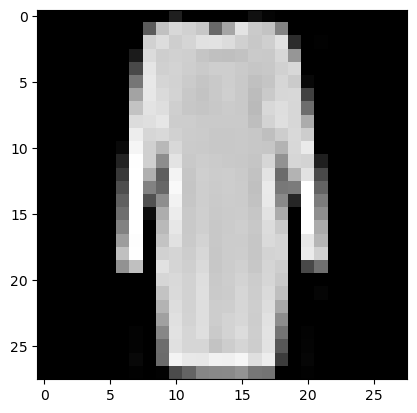

In [31]:
# Specific Sample Testing
test_sample_num = 301
x_test_fashion, num_inputs_test_fashion = read_mnist_images('../fashion_mnist/t10k-images-idx3-ubyte')
x_test_fashion_flat = x_test_fashion.reshape(-1, 784) / 255.
y_test_fashion = one_hot_encode(read_mnist_labels('../fashion_mnist/t10k-labels-idx1-ubyte'), 10)
network_fashion_dense.forward_propagation(x_test_fashion_flat[test_sample_num:test_sample_num+1, :], y_test_fashion)
print(f'Network Prediction: {np.argmax(network_fashion_dense.layers[-1].output)} - {fashion_interpretation_dict[np.argmax(network_fashion_dense.layers[-1].output)]}')
print(f'Correct Prediction: {np.argmax(y_test_fashion[test_sample_num])} - {fashion_interpretation_dict[np.argmax(y_test_fashion[test_sample_num])]}')
plt.imshow(x_test_fashion[test_sample_num], cmap='gray')


In [35]:
# General Evaluation
count = 0
for test_sample_num in range(num_inputs_test_fashion):
    network_fashion_dense.forward_propagation(x_test_fashion_flat[test_sample_num:test_sample_num+1, :], y_test_fashion[test_sample_num:test_sample_num+1])
    pred = np.argmax(network_fashion_dense.layers[-1].output)
    correct = np.argmax(y_test_fashion[test_sample_num])
    if pred != correct:
        count += 1
print(f'Accuracy on eval dataset: {100 - count/num_inputs * 100}%')


Accuracy on eval dataset: 81.24000000000001%


# Fashion MNIST model - CNN Architecture

In [39]:
x_fashion_image_reshaped = x_fashion.reshape(-1, 1, 28, 28) / 255.

In [53]:
# train the network yourself (TRAINING THIS NETWORK IS EXTREMELY SLOW)
network_fashion_cnn = Network([
    LayerConvolutional(2, 1, 3),
    LayerMaxPooling(),
    LayerConvolutional(3, 2, 3),
    LayerMaxPooling(),
    LayerFlatten(),
    LayerDense(147, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD(learning_rate=0.01))

epochs = 25
batch_size = 10

network_fashion_cnn.train(x_fashion_image_reshaped, y_fashion, epochs, batch_size)

epoch: 0, acc: 0.900, loss: 5.808
epoch: 1, acc: 0.900, loss: 5.000
epoch: 2, acc: 0.900, loss: 4.624
epoch: 3, acc: 0.900, loss: 4.365
epoch: 4, acc: 0.900, loss: 4.214
epoch: 5, acc: 0.900, loss: 4.132
epoch: 6, acc: 0.900, loss: 4.061
epoch: 7, acc: 0.900, loss: 4.022
epoch: 8, acc: 0.900, loss: 3.992
epoch: 9, acc: 0.900, loss: 3.968
epoch: 10, acc: 0.900, loss: 3.939
epoch: 11, acc: 0.800, loss: 3.918
epoch: 12, acc: 0.800, loss: 3.896
epoch: 13, acc: 0.800, loss: 3.870
epoch: 14, acc: 0.800, loss: 3.837
epoch: 15, acc: 0.800, loss: 3.791
epoch: 16, acc: 0.800, loss: 3.743
epoch: 17, acc: 0.800, loss: 3.694
epoch: 18, acc: 0.800, loss: 3.645
epoch: 19, acc: 0.800, loss: 3.606
epoch: 20, acc: 0.800, loss: 3.568
epoch: 21, acc: 0.800, loss: 3.536
epoch: 22, acc: 0.800, loss: 3.504
epoch: 23, acc: 0.800, loss: 3.470
epoch: 24, acc: 0.800, loss: 3.437


In [ ]:
# load network from file
network_fashion_cnn = Network()
network_fashion_cnn.load_from('../saved_models/fashion_cnn.json')

In [55]:
# save network to file
network_fashion_cnn.save_to('../saved_models/fashion_cnn.json')

In [54]:
# General Evaluation
count = 0
x_test_fashion_reshaped = x_test_fashion.reshape(-1, 1, 28, 28) / 255.
for test_sample_num in range(num_inputs_test_fashion):
    network_fashion_cnn.forward_propagation(x_test_fashion_reshaped[test_sample_num:test_sample_num+1, :, :, :], y_test_fashion[test_sample_num:test_sample_num+1])
    pred = np.argmax(network_fashion_cnn.layers[-1].output)
    correct = np.argmax(y_test_fashion[test_sample_num])
    if pred != correct:
        count += 1
print(f'Accuracy on eval dataset: {100 - count/num_inputs * 100}%')


Accuracy on eval dataset: 80.57%


Network Prediction: 1 - Trouser
Correct Prediction: 1 - Trouser


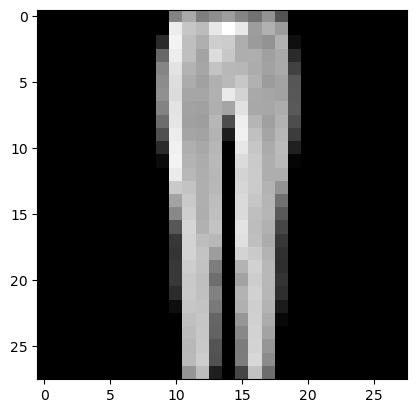

In [57]:
# Specific Sample Testing
test_sample_num = 345
network_fashion_cnn.forward_propagation(x_test_fashion_reshaped[test_sample_num:test_sample_num+1, :, :, :], y_test_fashion)
print(f'Network Prediction: {np.argmax(network_fashion_cnn.layers[-1].output)} - {fashion_interpretation_dict[np.argmax(network_fashion_cnn.layers[-1].output)]}')
print(f'Correct Prediction: {np.argmax(y_test_fashion[test_sample_num])} - {fashion_interpretation_dict[np.argmax(y_test_fashion[test_sample_num])]}')
plt.imshow(x_test_fashion_reshaped[test_sample_num, 0], cmap='gray')